# Origin prediction based on topography and fertility

#### Information
&copy; 2018 Peter Andras and Adam Stanton

School of Computer Science and Mathematics, Keele University, UK.

Please address correspondence to p.andras@keele.ac.uk or a.stanton@keele.ac.uk.

This notebook generates a statistically robust answer to the question of whether the origin sites of human cultures noted in the literature are closer than chance would expect to rugged mountainous regions that border fertile lowlands.

#### Method

Our approach is to use accurate topographical mapping of the surface of Earth to identify rugged, mountainous regions. We then identify where these regions border fertile lowland areas and, where the areas are within a certain distance of each other, mark them as potential origin points for advanced technical cultures.

For the ground-truth terrain data, we used the https://www.ngdc.noaa.gov/mgg/global/global.html ETOPO1 Global Relief Model. This is a 1 arc-minute global relief model build from global and regional data sets. 

For the land fertility data, we use the Harmonized World Soil Database from http://www.fao.org/soils-portal/soil-survey/soil-maps-and-databases/harmonized-world-soil-database-v12/en/. The FAO provide a preprocessed database for crop production, which is a 5 arc-minute map that parametrizes land according to characteristics such as organic carbon, pH, water capacity, salinity, and nutrients, putting each on a scale from 1 (high quality) to 4 (low quality). We upsample this data to match the resolution of the ETOPO1 terrain dataset.

To find rugged regions, we first apply the 2D laplacian operator to the relief map to highlight peaks and valleys in the landscape. We then take the absolute magnitude of each element, normalize across the output and apply an arbitrary threshold $\tau=0.3$ element-wise across the array. Next we apply a greyscale dilation of size $\lambda=40$ pixels (each pixel is equivalent to 1 arc-minute, or approximately 2km) to the output. The greyscale dilation can be viewed as a maximium filter over a sliding window, which spreads the identified areas beyond the mountainous regions towards lowland areas, up to around 40km from their focal point.

We then find the intersection of these regions with high-quality soil regions (where the quality index is 1 for all dimensions). These intersecting areas are then subject to another round of dilation of size $\rho=40$ pixels to form contiguous regions. Finally, the contiguous regions are enumerated, using a von Neumann neighbourhood structural parameter to specify connectedness.

The centres of mass (COMs) of these regions are considered to be potential origin points for advanced technical cultures. In order to identify a statistical relationship between these regions and the identified early cultural sites, we compare the mean distance from each COM to the nearest cultural site, to the mean distance of a null dataset of 10000 points drawn randomly from the high quality soil regions to the nearest cultural site. Where calculated or random points lie within sites, a distance of 0.0 is used.

#### File locations
The notebook expects to find ETOPO1 in ```./ETOPO1/ETOPO1_Ice_c_geotiff.tif``` and HWSD Crops in ```./soilquality/sq[1-7].asc```. It also stores images in ```./output/```.


In [1]:
tau=0.3 # Threshold for 'peakiniess' of landscape
lam=40  # Dilation factor for rugged areas
rho=40  # Dilation factor for creating contiguous origin regions

In [2]:
from osgeo import gdal
import struct

import math
import PIL.Image
import IPython.display
import shutil
from cStringIO import StringIO
from scipy import ndimage, stats
import numpy as np

def show_arrays(a, b, c=None, fmt='png', filename=None):
    rgb=np.zeros((len(a),len(a[0]), 3), 'uint8')
    rgb[...,0]=np.uint8(np.clip(a, 0, 255))
    rgb[...,1]=np.uint8(np.clip(b,0,255))

    if not c is None:
        rgb[...,2]=np.uint8(np.clip(c,0,255))
        
    image_data = StringIO()
    #im = PIL.Image.fromarray(rgb)
    PIL.Image.fromarray(rgb).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)
        
def show_array(a, fmt='png', filename=None):
    a = np.uint8(np.clip(a, 0, 255))
    image_data = StringIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

def ds_info(ds):
    print("Driver: {}/{}".format(ds.GetDriver().ShortName,
                             ds.GetDriver().LongName))
    print("Size is {} x {} x {}".format(ds.RasterXSize,
                                        ds.RasterYSize,
                                        ds.RasterCount))
    print("Projection is {}".format(ds.GetProjection()))
    geotransform = ds.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    print "[ RASTER BAND COUNT ]: ", ds.RasterCount
    for band in range( ds.RasterCount ):
        band += 1
        print "[ GETTING BAND ]: ", band
        srcband = ds.GetRasterBand(band)
        
        if srcband is None:
            continue

        print "[ NO DATA VALUE ] = ", srcband.GetNoDataValue()
        print "[ MIN ] = ", srcband.GetMinimum()
        print "[ MAX ] = ", srcband.GetMaximum()
        print "[ SCALE ] = ", srcband.GetScale()
        print "[ UNIT TYPE ] = ", srcband.GetUnitType()

        stats = srcband.GetStatistics( True, True )
        if stats is None:
            continue

        print "[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                    stats[0], stats[1], stats[2], stats[3] )

def findValleys(a):
    res=ndimage.laplace(a)
    res=abs(res)
    show_array(res,filename="output/00-laplacian.png")
    return res

def norm(a):
    a=a-np.min(a)
    a=a/np.max(a)
    return a

def findRegions(t, p, m): # terrain, population
    debug=True
    
    valley_dilation=lam
    region_dilation=rho
    
    print "Finding valleys..."
    valleys=findValleys(t)
    valleys=norm(valleys)

    p=np.sqrt(norm(p))
    
    print "Thresholding valleys..."
    # threshold strong values
    v_t=(valleys>tau)*valleys
    if debug: show_array(v_t*255.0, filename="output/01-valleys.png")
    p_t=p      
    if debug: show_array(p_t*255.0, filename="output/02-fertility.png")
    
    print "Growing the valleys..."
    # grow the valley regions to overlap the fertile regions
    v_t=ndimage.grey_dilation(v_t, size=(valley_dilation,valley_dilation))
    if debug: show_array(v_t*255.0, filename="output/03-valleys_grown.png")

    print "Producing final map..."
    # produce final map of interesting regions by combining identified valleys and fertile regions
    final=ndimage.grey_dilation(v_t*p_t, size=(region_dilation,region_dilation))
    if debug: show_array(final*255.0, filename="output/04-final.png")
            
    print "Collecting regions..."
    structure=[[0,1,0],[1,1,1],[0,1,0]]
    lbl,numlbl = ndimage.label(final,structure=structure)
    com=ndimage.measurements.center_of_mass(final,lbl,np.unique(lbl)[1:])
    print "Found " + str(numlbl) + " candidate regions."

    print "Tidying up coastlines..."
    final=final*m
    
    print "Done."
    return [final,lbl,numlbl,com]


In [3]:
filename="ETOPO1/ETOPO1_Ice_c_geotiff.tif"
terrain_ds = gdal.Open(filename, gdal.GA_ReadOnly)
print "TERRAIN INFO\n------------"
geotransform=terrain_ds.GetGeoTransform()
terrain = terrain_ds.ReadAsArray()
vfn=np.vectorize(lambda t: 1.0 if t>0 else 0.0)
tmask=vfn(terrain)
# Let's remove the sea:
terrain = terrain*tmask

def convImageToLatLong(imgCoord):

    # degrees per pixel long 
    longDegFromBaseline=imgCoord[1] * geotransform[1] - 180.0
    longBaseline=0
    longFinal = longBaseline+longDegFromBaseline

    latDegFromBaseline=90.0 - imgCoord[0] * -geotransform[5]
    latBaseline=0
    latFinal = latBaseline+latDegFromBaseline 

    return [latFinal, longFinal]

TERRAIN INFO
------------


In [4]:
# Load fertility data
from numpy import genfromtxt
print "Reading soil quality data: sq1.asc..."
my_data = genfromtxt('soilquality/sq1.asc', delimiter=' ',skip_header=5)
sq_data = (my_data==1) #+ (my_data==2)

for f in ['sq2.asc','sq3.asc','sq4.asc','sq5.asc','sq6.asc','sq7.asc']:
    print "Reading soil quality data: " + f + "..."
    my_data = genfromtxt('soilquality/'+f,delimiter=' ',skip_header=5)
    sq_data = sq_data*((my_data==1))# + (my_data==2))

print "Upscaling resolution to match terrain data ... "
fertility=np.repeat(sq_data,5,axis=1)
fertility=np.repeat(fertility,5,axis=0)
fertility=np.uint8(fertility)


Reading soil quality data: sq1.asc...
Reading soil quality data: sq2.asc...
Reading soil quality data: sq3.asc...
Reading soil quality data: sq4.asc...
Reading soil quality data: sq5.asc...
Reading soil quality data: sq6.asc...
Reading soil quality data: sq7.asc...
Upscaling resolution to match terrain data ... 


# Execute the algorithm to find the hotspots
## final[3] contains the pairs

In [6]:
final=findRegions(terrain,fertility,tmask)

Finding valleys...
Thresholding valleys...
Growing the valleys...
Producing final map...
Found 204 candidate regions.
Tidying up coastlines...
Done.


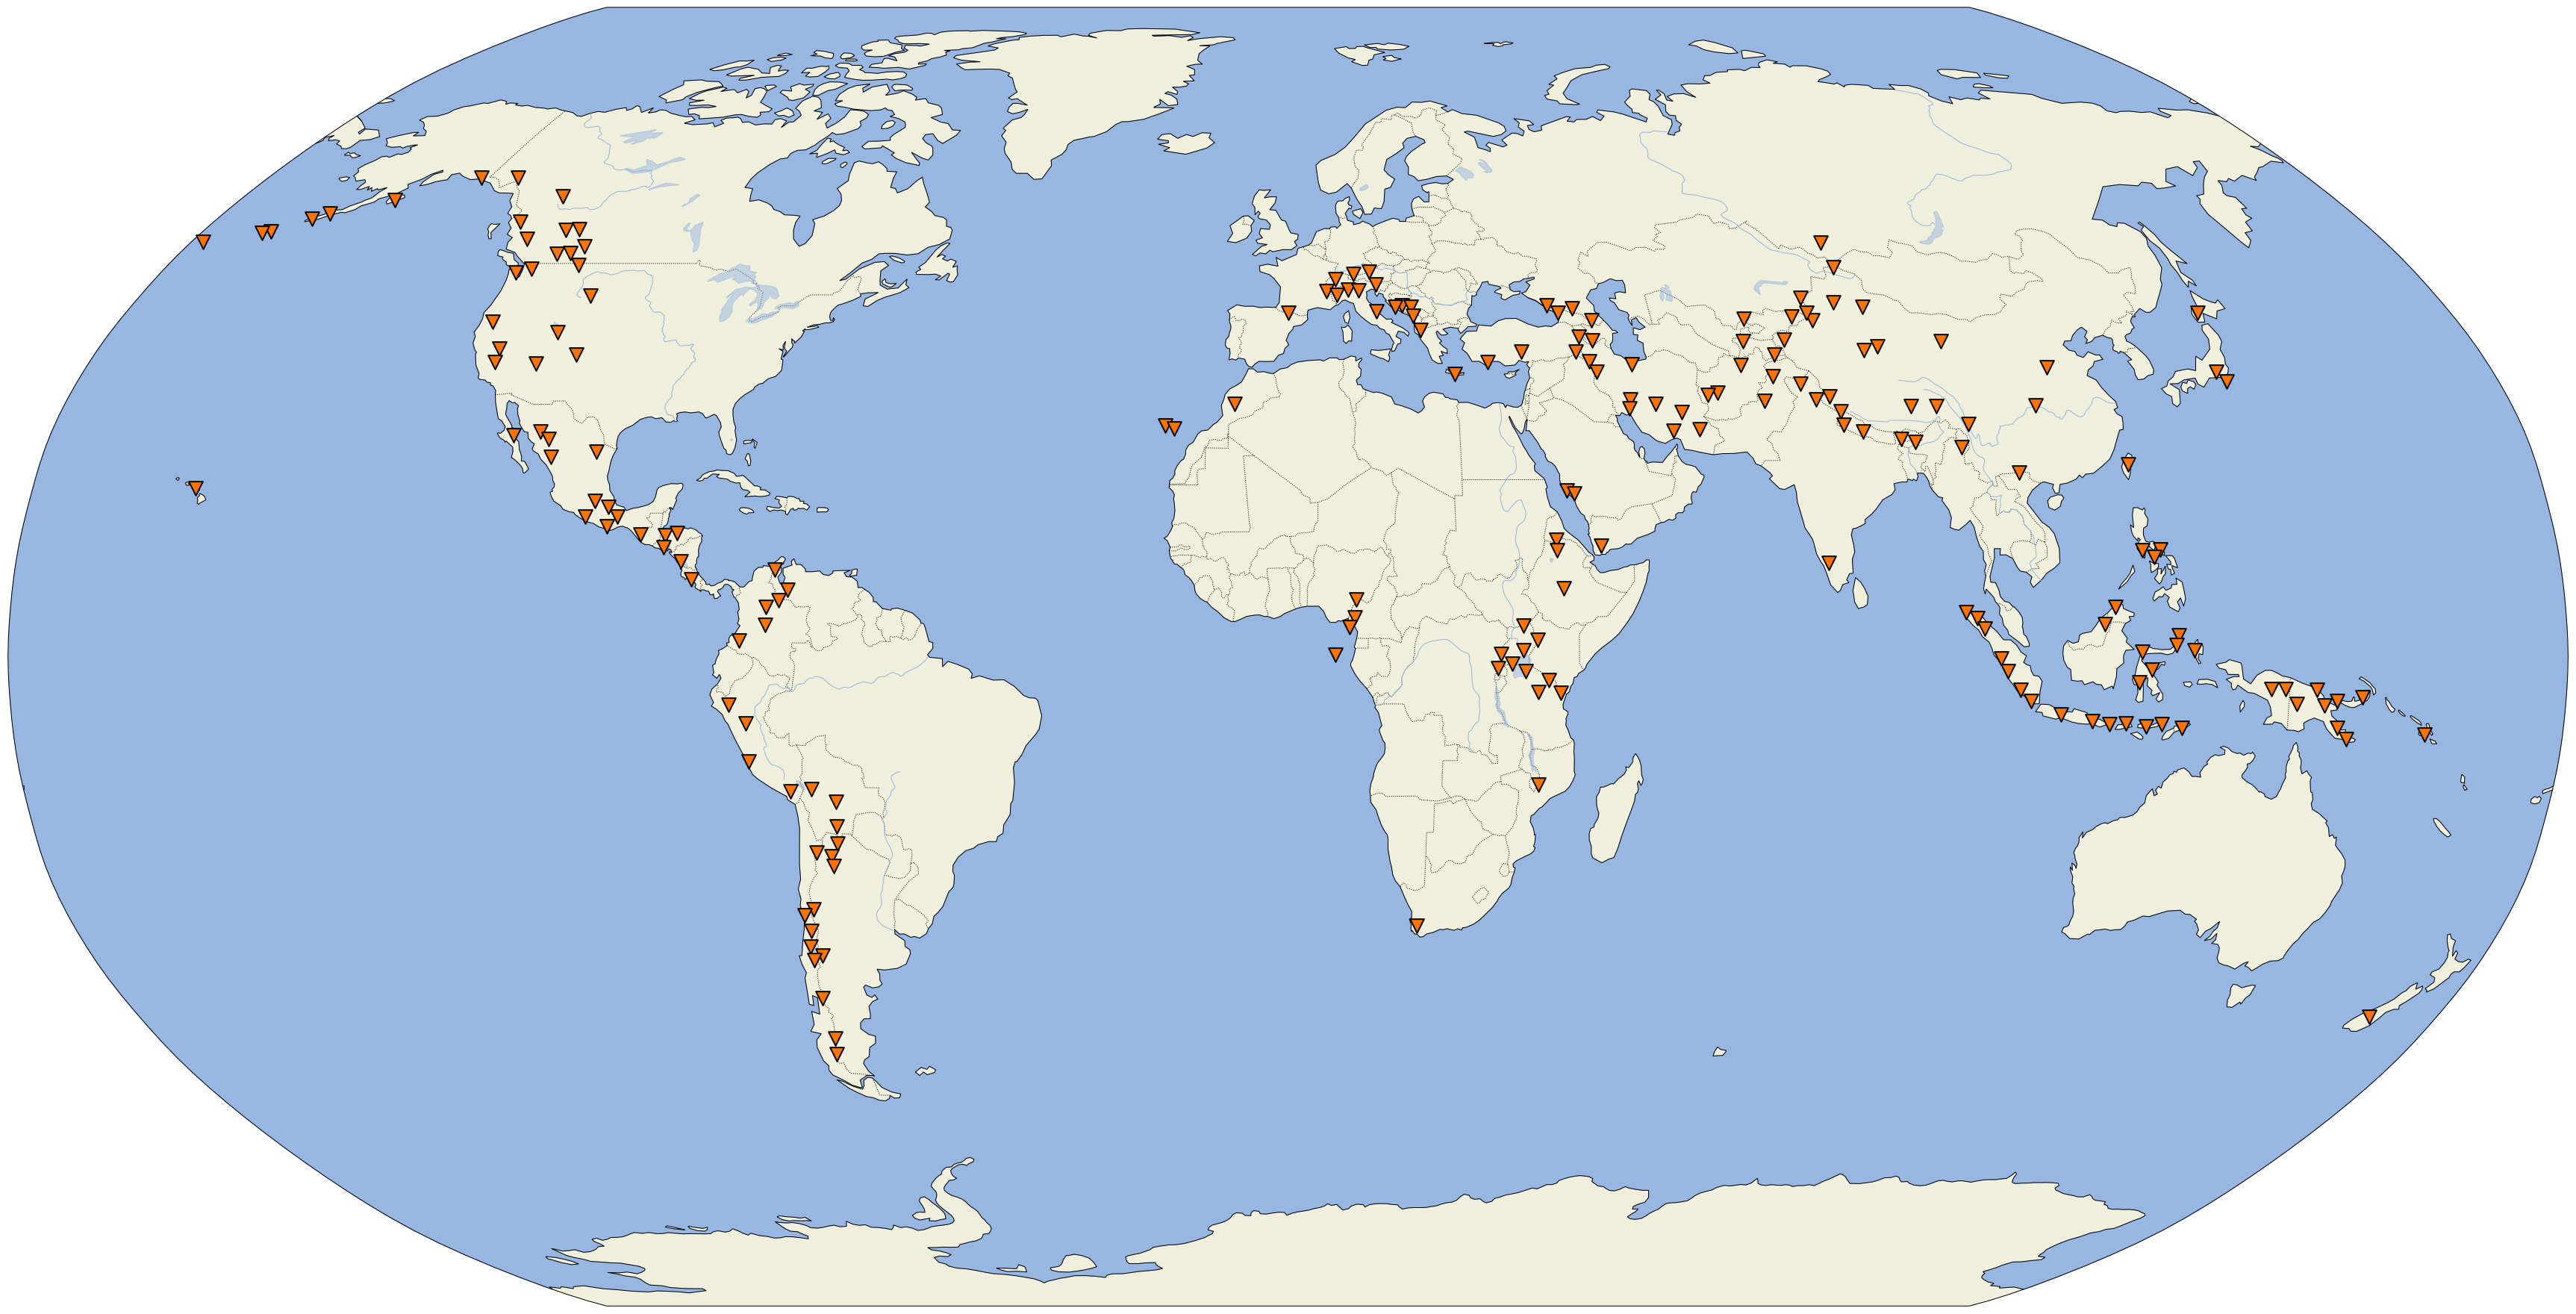

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

longret=[]
latiret=[]
    
for x in final[3]:
    la,lo=convImageToLatLong(x)
    latiret=latiret+[la]
    longret=longret+[lo]

fig=plt.figure(figsize=(64, 32))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

tmp =  ax.add_feature(cfeature.LAND)
tmp =  ax.add_feature(cfeature.OCEAN)
tmp =  ax.add_feature(cfeature.COASTLINE)
tmp =  ax.add_feature(cfeature.BORDERS, linestyle=':')
tmp =  ax.add_feature(cfeature.LAKES, alpha=0.5)
tmp =  ax.add_feature(cfeature.RIVERS)

tmp = ax.scatter(longret, latiret, s=350, alpha=1.0, c="#ff7303", linewidth=2, marker='v', 
           zorder=10000, edgecolors=["#020202"], transform=ccrs.Geodetic())
plt.show()
fig.savefig("output/05-world.png")

### Culture Origin Regions

In [8]:
regions=dict()
regions['celts']=[[(44.64,5.75), (46.53,14.08), (48.02,14.33), (47.40,6.66)],
       [(48.45,7.54), (49.07,11.71), (48.20,12.73), (48.05,8.76)]]
                                                                    
regions['early_indo_europeans'] = [[(44.15,39.58), (42.63,41.59), (41.06,47.29), (42.50,46.91)],
                        [(41.42,42.67), (41.18,44.39), (40.11,44.48), (40.63,42.36)]]

regions['indo_europeans_d_v'] = [[(48.68,34.56), (49.63,45.06), (46.27,49.32), (45.22,36.25)]]

regions['turkic_mongol_highlands'] = [[(46.29,85.48), (42.53,88.78), (38.38,68.40), (40.33,67.86)]]

regions['turkic_mongol_fergana'] = [[(40.16,69.89), (40.74,70.20), (41.42,71.97), (40.45,72.95)]]

regions['austronesians_highlands'] = [[(22.75,120.44), (22.04,120.89), (24.98,121.90), (24.86,121.20) ]]

regions['austronesians'] = [[(23.04,120.03), (22.93,120.31), (24.39,120.69), (24.15,120.17)]]

regions['semitic_kushitic_highlands'] = [[(7.15,35.65), (7.67,38.25), (5.08,39.75), (4.83,35.28)]]

regions['semitic_kushitic'] = [[(9.42,36.16), (9.60,39.64), (7.54,39.44), (7.70,36.69)]]

regions['bantu'] = [[(6.40,6.79), (6.51,7.84), (5.08,8.01), (4.98,6.79)]]

regions['korean_japanese_manchu'] = [[(55.63,121.51), (50.43,138.53), (43.06,133.35), (43.70,116.72)]]

regions['anatolian_farmers'] = [[(37.94,39.01), (38.16,41.28), (37.76,40.82), (37.33,39.66)]]

regions['tibeto_burmese_tai_kadai'] = [[(22.54,99.04), (23.42,103.40), (29.59,102.79), (29.72,98.20)]]

regions['germanics'] = [[(58.94,5.92), (61.39,11.78), (64.19,13.81), (62.24,5.26)]]

regions['germanics_lowlands'] = [[(53.99,8.89), (57.04,8.43), (57.93,11.93), (55.42,14.14) ]]

regions['slavs'] = [[(49.95,25.65), (49.92,31.02), (48.25,32.18), (48.47,26.51)]]

regions['inca'] = [[(-18.15,-65.57), (-18.07,-63.51), (-12.24,-71.93), (-12.87,-75.12)]]

regions['maya'] = [[(17.19,-90.99), (17.03,-89.24), (15.88,-89.86), (16.41,-90.56)]]

regions['papua'] = [[(-3.21,135.83), (-4.36,135.39), (-5.23,140.88), (-4.49,140.91)], 
         [(-5.23,140.88), (-4.49,140.91), (-6.25,147.56), (-9.29,144.65) ]]

regions['greeks'] = [[(37.15,21.39), (37.95,22.99), (36.56,23.06), (36.88,21.73) ]]

regions['australian_aboriginies'] = [[(-11.22,130.40), (-12.07,134.19), (-14.97,132.87), (-14.80,129.75)]]

regions['hominids'] = [[(12.00,39.84), (-10.00,33.85), (2.84,30.74), (12.27,37.72)],
            [(-15.27,34.80), (-30.49,27.06), (-26.49,23.09), (-13.77,32,24)]]

regions['east_beringia'] = [[(60.95,-155.26),(65.37,-144.89),(58.84,-123.79),(54.93,-130.30)]]


In [9]:
numbering=dict()
numbering['celts']=1
numbering['early_indo_europeans'] = 2
numbering['indo_europeans_d_v'] = 3
numbering['turkic_mongol_highlands'] = 4
numbering['turkic_mongol_fergana'] = 5
numbering['austronesians_highlands'] = 6
numbering['austronesians'] = 7
numbering['semitic_kushitic_highlands'] = 8
numbering['semitic_kushitic'] = 9
numbering['bantu'] = 10
numbering['korean_japanese_manchu'] = 11
numbering['anatolian_farmers'] = 12
numbering['tibeto_burmese_tai_kadai'] = 13
numbering['germanics'] = 14
numbering['germanics_lowlands'] = 15
numbering['slavs'] = 16
numbering['inca'] = 17
numbering['maya'] = 18
numbering['papua'] = 19
numbering['greeks'] = 20
numbering['australian_aboriginies'] = 21
numbering['hominids'] = 22
numbering['east_beringia'] = 23


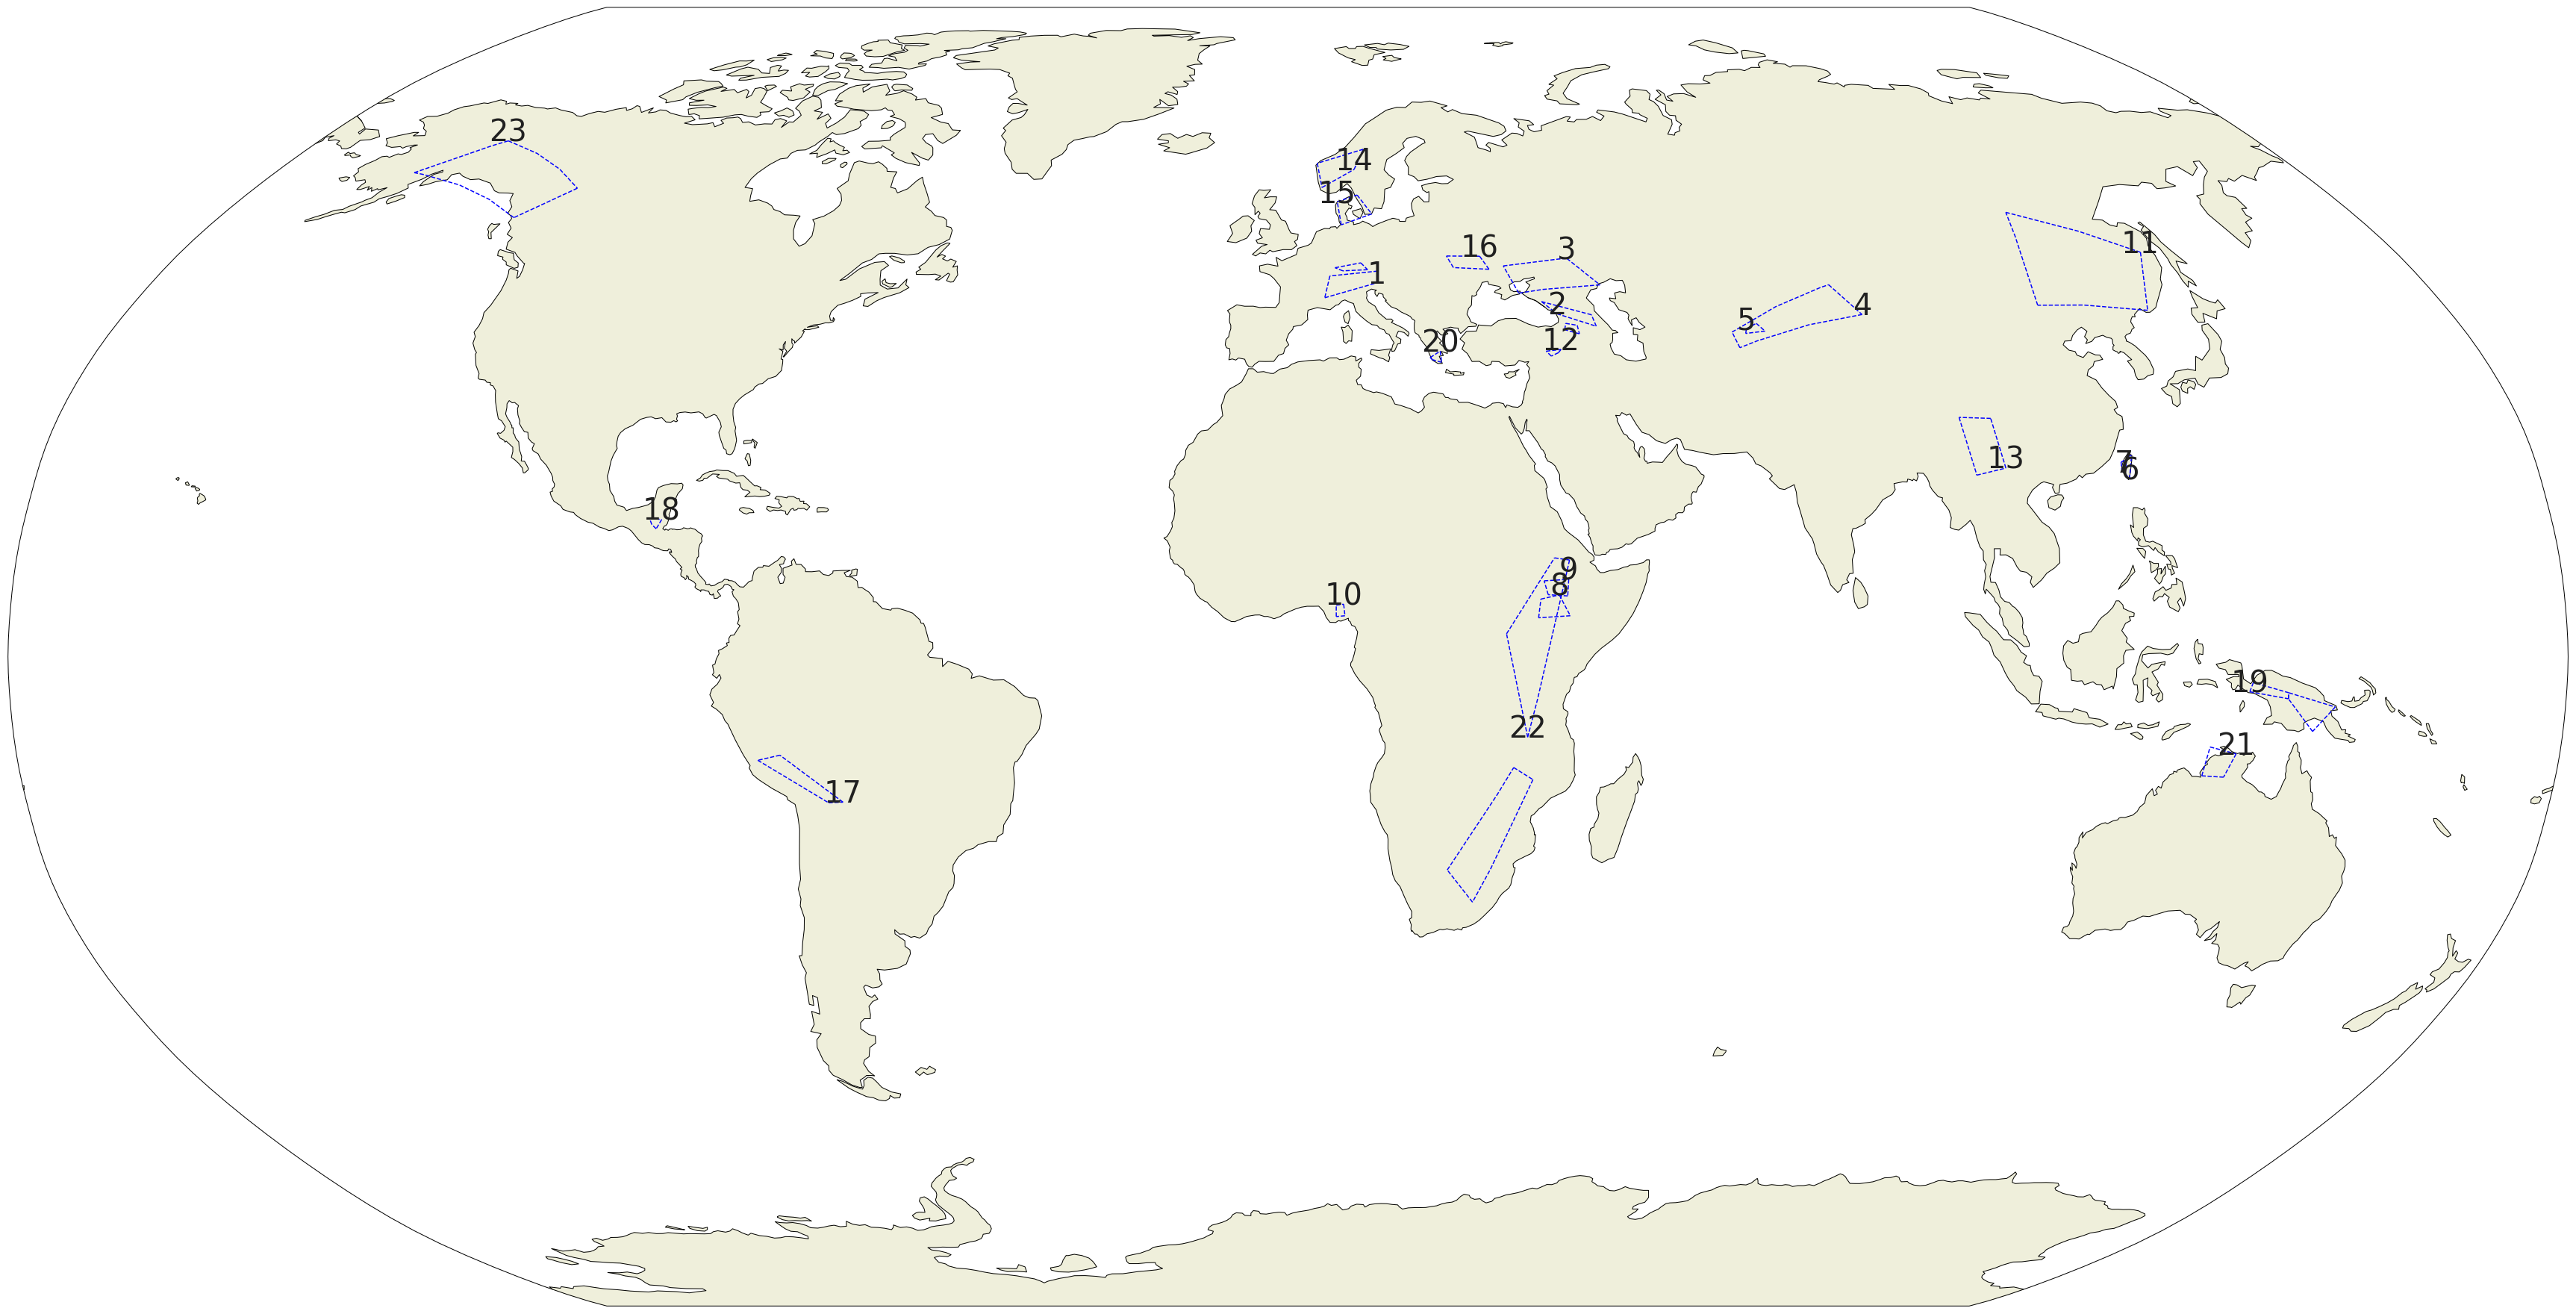

In [10]:
# Plot points
fig=plt.figure(figsize=(64, 32))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
tmp =  ax.add_feature(cfeature.LAND)
tmp =  ax.add_feature(cfeature.COASTLINE)
last="foo"
for k,v in regions.iteritems():
    for q in v:
        plt.plot([q[0][1], q[1][1]], [q[0][0], q[1][0]], color='blue', linestyle='--', transform=ccrs.Geodetic() )
        plt.plot([q[1][1], q[2][1]], [q[1][0], q[2][0]], color='blue', linestyle='--', transform=ccrs.Geodetic() ) 
        plt.plot([q[2][1], q[3][1]], [q[2][0], q[3][0]], color='blue', linestyle='--', transform=ccrs.Geodetic() )
        plt.plot([q[3][1], q[0][1]], [q[3][0], q[0][0]], color='blue', linestyle='--', transform=ccrs.Geodetic() )        
        if last!=k:
            plt.text(q[1][1], q[1][0], numbering[k], color='#202020',fontsize=40,horizontalalignment='center', transform=ccrs.Geodetic())
            last=k
plt.show()
fig.savefig("output/06-regions.png")


In [11]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
regions_poly=dict()
for k,v in regions.iteritems():
    tmp=[]
    for p in v:
        tmp=tmp+[Polygon(p)]
    regions_poly[k]=tmp


In [12]:
# calculate average distance from found points in final[3] to regions:
s=0
count=0
test=[]
for lat,lon in zip(latiret, longret):
    smallest=9999999999.9
    for k,v in regions_poly.iteritems():
        for poly in v:
            d = poly.distance(Point(lat,lon))
            if d<smallest:
                smallest=d
                smr=k
    s=s+smallest
    test=test+[smallest]
    count=count+1

print "Count: " + str(count)
print "Average distance: " + str(round(s/count,3))

Count: 204
Average distance: 8.746


In [13]:
s=0
count=0
control=[]
for x in range(10000):
    if x % 1000 == 0: print x
    sample=0
    while sample==0:
        y=np.random.randint(0,10800)
        x=np.random.randint(0,21600)
        sample = fertility[y][x]
    lat,lon = convImageToLatLong([y,x])
    smallest=9999999999.9
    for k,v in regions_poly.iteritems():
        for poly in v:
            d = poly.distance(Point(lat,lon))
            if d<smallest:
                smallest=d
                smr=k    
    s=s+smallest
    control=control+[smallest]
    count=count+1

print "Count: " + str(count)
print "Average distance: " + str(round(s/count,3))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Count: 10000
Average distance: 10.991


In [14]:
from scipy import stats
stats.ttest_ind(test,control)

Ttest_indResult(statistic=-3.5545490011672842, pvalue=0.00038034050917016334)

In [15]:
import pandas as pd
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1['control']=control
df2['test']=test
#df['test']=test
df=pd.concat([df1,df2],ignore_index=True, axis=1)
df.columns=['control','test']
df.describe()

,control,test
count,10000.000000,204.000000
mean,10.990756,8.745730
std,8.938498,8.517483
min,0.000000,0.000000
25%,3.206064,1.508692
50%,9.188290,6.720477
75%,17.695732,13.320633
max,56.664811,43.228276
